# Spatial data analysis - practical exercises


First install some libraries which are not in the basic anaconda distribution:

```
pip install pyshp
pip install GPy
```

In [1]:
import pandas as pd
from sklearn import model_selection, neighbors, metrics ,linear_model, tree, ensemble
import GPy
import networkx as nx
from IPython.display import Image
import ugplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Read in the name/frequency/location data. The variable j_per_k is the number of Johns per thousand people in the small area around the corresponding longitude and latitude.

In [2]:
namefreq = pd.DataFrame(pd.read_csv('johns_per_1000.csv'))
namefreq

,lon,lat,j_per_k
0,33.636677,2.830464,1.351370
1,33.624261,2.769444,1.578002
2,33.638374,2.789150,1.209234
3,33.661324,2.518131,1.745767
4,31.905891,3.447542,0.695969
5,31.592780,2.946572,0.805657
6,31.686658,3.461286,0.881894
7,31.646327,3.262606,0.658075
8,33.278597,3.016495,1.242036
9,33.435000,3.269801,1.011804


Have a look at the data

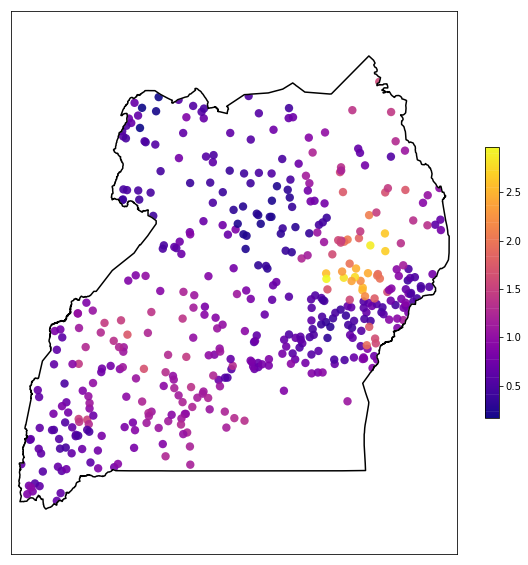

In [3]:
ugplot.plot_country_outline()
sc = scatter(namefreq.lon, 
             namefreq.lat, 
             c=namefreq.j_per_k, 
             cmap=plt.cm.plasma,
             s=70,alpha=.9,
             edgecolors='none')
plt.colorbar(sc,shrink=.5)
#ugplot.prettify_map(show_reserves=False)
gcf().set_size_inches(10,10)

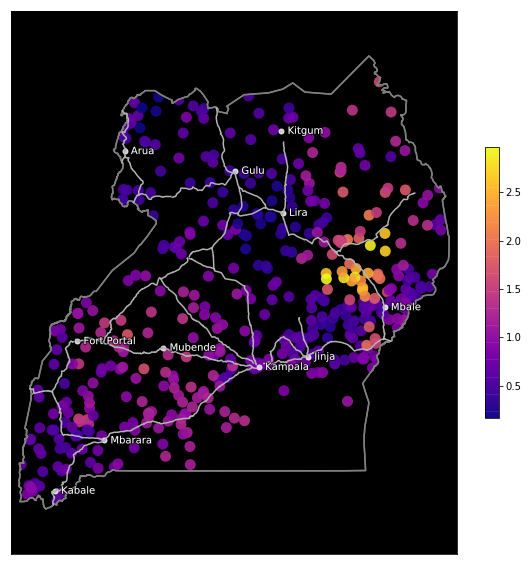

In [4]:
ugplot.plot_country_outline(outline_colour=(.5,.5,.5),background_colour='black')
sc = scatter(namefreq.lon, 
             namefreq.lat, 
             c=namefreq.j_per_k, 
             cmap=plt.cm.plasma,
             s=120,alpha=.9,
             edgecolors='none')
plt.colorbar(sc,shrink=.5)
gca().set_facecolor("black")
ugplot.prettify_map(label_colour='white',label_shadow='black',water_colour=(100,100,100),
                    outline_colour=(.5,.5,.5),show_reserves=False,background_colour=(.0,.0,.0))
gcf().set_size_inches(10,10)

Split up the data into training and test sets

In [5]:
X = np.vstack((namefreq.lon,namefreq.lat)).transpose()
y = np.array(namefreq.j_per_k)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2)

Some useful stuff for visualising the model outputs.

Create a grid of coordinates across Uganda. We will then get predictions at each of these points and plot them on a map.

In [6]:
def plot_model_predictions_on_map(model):
    ypred_grid = model.predict(np.array([xv.ravel(),yv.ravel()]).transpose())
    ugplot.plot_uganda_cropped_image(ypred_grid.reshape(yv.shape), cmap=cm.plasma,vmin=min(ypred_grid),vmax=max(ypred_grid))
    ugplot.plot_country_outline()
    gcf().set_size_inches(8,8)
    
UG_min_lon = 29.571499
UG_max_lon = 35.000273
UG_min_lat = -1.47887
UG_max_lat = 4.234466
pixels_per_degree = 40.
numx = int((UG_max_lon-UG_min_lon)*pixels_per_degree)
numy = int((UG_max_lat-UG_min_lat)*pixels_per_degree)
mask = np.zeros((numy,numx))
x1 = np.linspace(UG_min_lon, UG_max_lon, numx)
x2 = np.linspace(UG_min_lat, UG_max_lat, numy)
xv, yv = meshgrid(x1, x2)

### Super simple model: predict the mean of the training data.

In [7]:
y_pred = np.ones(y_test.shape)* np.mean(y_train)

print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test,y_pred)))

MAE: 0.329


### Neighbourhood and distance-based predictions

In [8]:
#using neighbors regression model
#model = neighbors.KNeighborsRegressor(n_neighbors=10,weights='distance')
#using linear_regression model
#model = linear_model.LinearRegression()
#using tree decision model
#model = tree.DecisionTreeRegressor()
#using random forest regression model
model = ensemble.RandomForesterRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_model_predictions_on_map(model)
ugplot.prettify_map(label_colour='white',label_shadow='black',water_colour=(100,100,100),
                    outline_colour=(.5,.5,.5),show_reserves=False)

print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test,y_pred)))

AttributeError: module 'sklearn.ensemble' has no attribute 'RandomForesterRegressor'

### Gaussian processes

We can model the name distribution by assuming the frequency of a name $y^{(i)}$ at a location $\mathbf{x}^{(i)}$ is strongly related to the name distribution $y^{(j)}$ at location $\mathbf{x}^{(j)}$ if these locations are close together. The further away the locations are, the less they affect each other.

This could be specified with a kernel:
$k(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) \;=\; \exp\!\bigg(-{\textstyle\frac{1}{2}}
    \sum_{d=1}^D (x_d^{(i)} - x_d^{(j)})^2 / \ell^2
    \bigg)$
where here $D=2$. 

We have to set $\ell$ somehow... we can start with a guess of .3 degrees (about 30km near the equator), then try to optimise.

In [ ]:
# define kernel
kernel = GPy.kern.RBF(2,lengthscale=.3)

# create simple GP model
model = GPy.models.GPRegression(X_train,np.array([y_train]).transpose(),kernel)

# OPTIONAL: optimise the parameters
model.optimize(messages=True,max_f_eval = 1000)

ypred_grid, S = model.predict(np.array([xv.ravel(),yv.ravel()]).transpose())
ugplot.plot_uganda_cropped_image(ypred_grid.reshape(yv.shape), cmap=cm.plasma,vmin=min(ypred_grid),vmax=max(ypred_grid))
ugplot.prettify_map(label_colour='white',label_shadow='black',water_colour=(100,100,100),
                    outline_colour=(.5,.5,.5),show_reserves=False)

gcf().set_size_inches(8,8)

y_pred, S_pred = model.predict(X_test)
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test,y_pred)))

### There are many ways to calculate distance

In different contexts, different distance measures might be relevant. For example, shortest distance or time along the road network might be helpful. The Python library networkx can be used to calculate that.

In [ ]:
Image("uganda-road-network.png",width=500)

### Exercise: Parameter fitting

Use cross validation to find the best parameters on the training set, then evaluate on the test set.

*Part 1*: What is the test error for the optimum value of *k* in a *k*-nearest-neighbour regression model?

In [ ]:
k_settings = range(1,10)
crossvalidation_error = []

for k in k_settings:
    model = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance') 
    cv_error = model_selection.cross_val_score(model,X_train,y_train,
                                               scoring=metrics.make_scorer(metrics.mean_absolute_error),cv=5)
    crossvalidation_error.append(np.mean(cv_error))

plot(k_settings,crossvalidation_error)
title('Error with cross-validation on training set')
xlabel('k')
ylabel('Cross-validated MAE')

*Part 2*: Try modifying this code to find a model with even better predictions (lower test MAE) of the number of Johns in each place. For example, there are many other types of regression models. Some examples:

```
sklearn.linear_model.LinearRegression
sklearn.tree.DecisionTreeRegressor
sklearn.ensemble.RandomForestRegressor
```

Looking at the predictions that these models make across the map helps to understand how these models are working.